In [1]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import seaborn as sns

ModuleNotFoundError: No module named 'torch'

In [2]:
!pip install torch

  Using cached torch-2.6.0-cp312-cp312-manylinux1_x86_64.whl.metadata (28 kB)
  Using cached filelock-3.17.0-py3-none-any.whl.metadata (2.9 kB)
  Using cached networkx-3.4.2-py3-none-any.whl.metadata (6.3 kB)
  Using cached nvidia_cuda_nvrtc_cu12-12.4.127-py3-none-manylinux2014_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_runtime_cu12-12.4.127-py3-none-manylinux2014_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_cupti_cu12-12.4.127-py3-none-manylinux2014_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cudnn_cu12-9.1.0.70-py3-none-manylinux2014_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cublas_cu12-12.4.5.8-py3-none-manylinux2014_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cufft_cu12-11.2.1.3-py3-none-manylinux2014_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_curand_cu12-10.3.5.147-py3-none-manylinux2014_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cusolver_cu12-11.6.1.9-py3-none-manylinux2014_x86_64.whl.metadata (1.6 kB)
  Using cached 

In [ ]:
df = pd.read_csv("Livia Lima Bion - meds_train_alunos.csv")

In [ ]:
#Selecionar colunas numéricas para treinamento da GAN
feature_columns = [col for col in df.columns if col.startswith('rssi') or col.startswith('delay')]
scaler = MinMaxScaler()
data = scaler.fit_transform(df[feature_columns].dropna())

In [ ]:
#Definição da GAN
latent_dim = 20  #vetor de ruído
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(latent_dim, 128),
            nn.LeakyReLU(0.2),
            nn.BatchNorm1d(128),
            nn.Linear(128, 256),
            nn.LeakyReLU(0.2),
            nn.BatchNorm1d(256),
            nn.Linear(256, 512),
            nn.LeakyReLU(0.2),
            nn.BatchNorm1d(512),
            nn.Linear(512, data.shape[1]),
            nn.Tanh()  #Normalizado entre -1 e 1
        )

    def forward(self, z):
        return self.model(z)

#Modelo Discriminador Melhorado
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(data.shape[1], 512),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),  #Para evitar overfitting
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            nn.Linear(256, 128),
            nn.LeakyReLU(0.2),
            nn.Linear(128, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.model(x)

In [ ]:
#Criar modelos e otimizadores
generator = Generator()
discriminator = Discriminator()

criterion = nn.BCELoss()
optimizer_G = optim.Adam(generator.parameters(), lr=0.0005, betas=(0.5, 0.999))  #Learning rate menor para mais estabilidade
optimizer_D = optim.Adam(discriminator.parameters(), lr=0.0002, betas=(0.5, 0.999))

In [ ]:
#Treinamento
num_epochs = 10000  #Mais épocas para maior qualidade
batch_size = 128  #Aumentar batch melhora estabilidade

for epoch in range(num_epochs):
    # Criar batches de dados reais
    idx = np.random.randint(0, data.shape[0], batch_size)
    real_samples = torch.tensor(data[idx], dtype=torch.float32)

    # Criar labels (1 para reais, 0 para gerados)
    real_labels = torch.ones((batch_size, 1))
    fake_labels = torch.zeros((batch_size, 1))

    # Treinar o Discriminador
    optimizer_D.zero_grad()
    z = torch.randn(batch_size, latent_dim)
    fake_samples = generator(z)
    real_loss = criterion(discriminator(real_samples), real_labels)
    fake_loss = criterion(discriminator(fake_samples.detach()), fake_labels)
    d_loss = real_loss + fake_loss
    d_loss.backward()
    optimizer_D.step()

    # Treinar o Gerador
    optimizer_G.zero_grad()
    g_loss = criterion(discriminator(fake_samples), real_labels)  # O gerador quer enganar o discriminador
    g_loss.backward()
    optimizer_G.step()

    # Monitorar progresso a cada 1000 épocas
    if epoch % 1000 == 0:
        print(f"Epoch {epoch}: D_loss={d_loss.item():.4f}, G_loss={g_loss.item():.4f}")

Epoch 0: D_loss=1.3845, G_loss=0.7312
Epoch 1000: D_loss=1.2868, G_loss=0.8059
Epoch 2000: D_loss=1.2034, G_loss=0.9034
Epoch 3000: D_loss=1.1905, G_loss=0.9234
Epoch 4000: D_loss=1.2779, G_loss=0.9500
Epoch 5000: D_loss=1.1094, G_loss=1.2249
Epoch 6000: D_loss=1.0795, G_loss=1.4141
Epoch 7000: D_loss=1.1424, G_loss=1.1257
Epoch 8000: D_loss=0.9735, G_loss=1.7930
Epoch 9000: D_loss=1.0707, G_loss=1.4026


In [ ]:
# **Geração de 20.325 amostras**
num_samples = 20325
z = torch.randn(num_samples, latent_dim)
generated_data = generator(z).detach().numpy()
generated_data = scaler.inverse_transform(generated_data)

In [ ]:
# Salvar os novos dados
df_generated = pd.DataFrame(generated_data, columns=feature_columns)
df_generated.to_csv("generated_data_20325.csv", index=False)

print("Dados sintéticos gerados e salvos em 'generated_data_20325.csv'.")

Dados sintéticos gerados e salvos em 'generated_data_20325.csv'.


Verificacao

In [ ]:
# Carregar os datasets
df_real = pd.read_csv("Livia Lima Bion - meds_train_alunos.csv")
df_sintetico = pd.read_csv("generated_data_20325.csv")

# Selecionar apenas as colunas numéricas (rssi_* e delay_*)
feature_columns = [col for col in df_real.columns if col.startswith('rssi') or col.startswith('delay')]

# Calcular estatísticas
stats_real = df_real[feature_columns].describe()
stats_sintetico = df_sintetico[feature_columns].describe()


In [ ]:
# Comparar estatísticas lado a lado
print("📊 Estatísticas dos dados reais:")
print(stats_real)
print("\n📊 Estatísticas dos dados sintéticos:")
print(stats_sintetico)

📊 Estatísticas dos dados reais:
          rssi_1_1     rssi_1_2     rssi_1_3     rssi_2_1     rssi_2_2  \
count  6775.000000  6775.000000  6775.000000  6775.000000  6775.000000   
mean   -100.789923  -105.688802  -100.545198  -103.524786   -97.210290   
std      10.025728    10.397924     9.968138    13.367328     8.853480   
min    -115.000000  -115.000000  -115.000000  -115.000000  -115.000000   
25%    -107.650000  -115.000000  -107.148571  -115.000000  -102.202857   
50%    -103.040000  -110.425000   -99.750000  -108.430000   -97.170000   
75%     -93.455000   -97.350000   -93.340000   -96.817917   -92.080000   
max     -61.380000   -64.820000   -60.640000   -36.960000   -59.170000   

          rssi_2_3     rssi_3_1     rssi_3_2     rssi_3_3      delay_1  \
count  6775.000000  6775.000000  6775.000000  6775.000000  6775.000000   
mean    -97.193499   -93.644749   -93.353728  -107.478361     4.679410   
std       9.992950     7.688089     8.110877    11.003407     0.911469   
min  

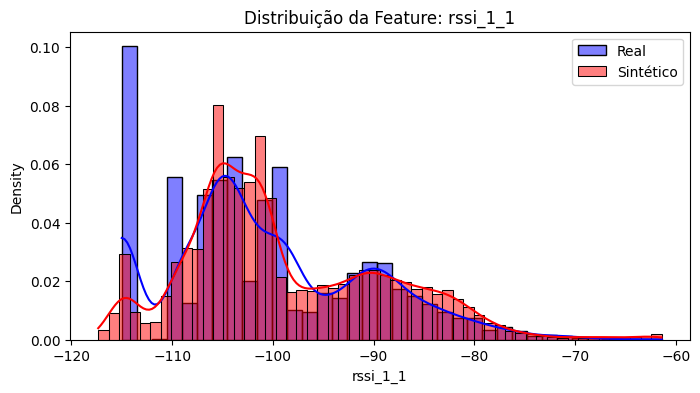

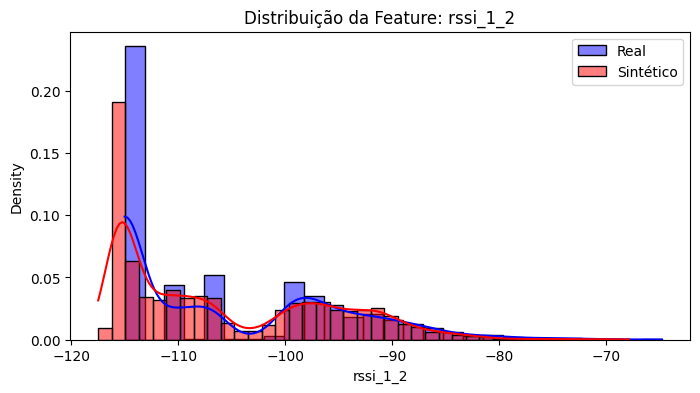

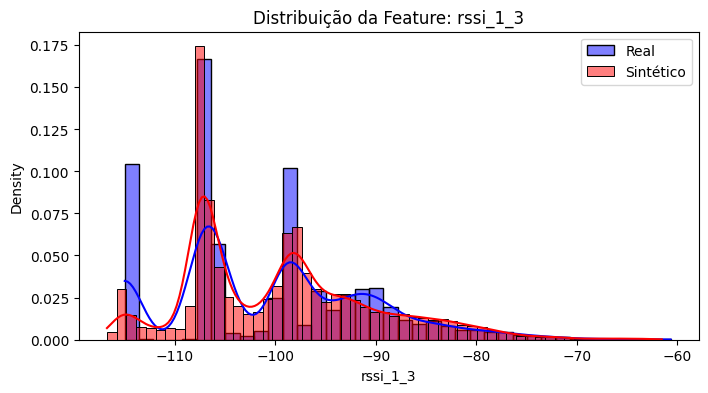

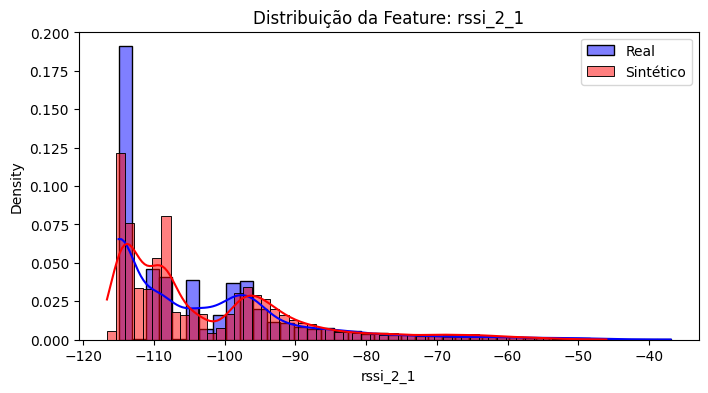

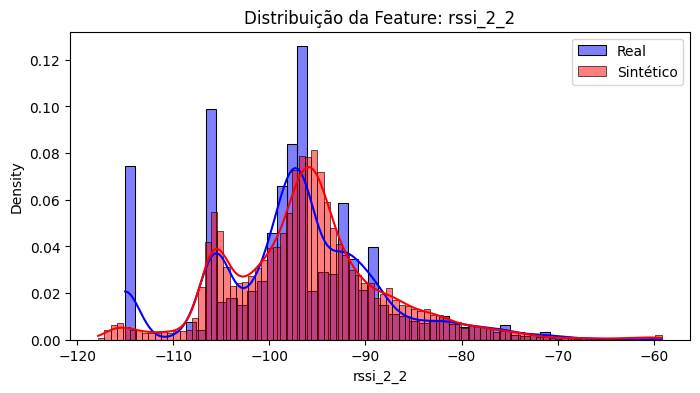

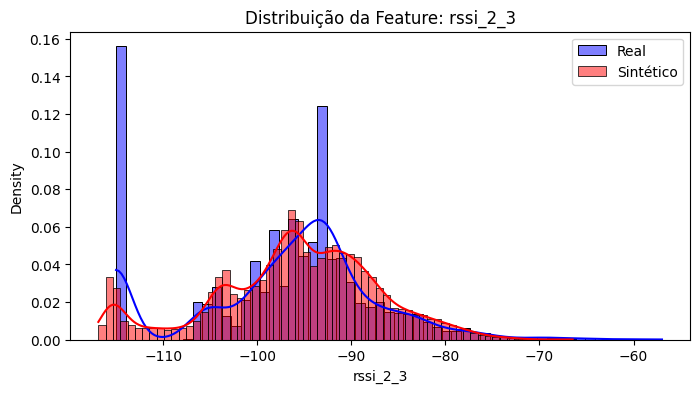

In [ ]:
# Visualizar histogramas para algumas colunas
for col in feature_columns[:6]:  # Pegamos só algumas para não sobrecarregar os gráficos
    plt.figure(figsize=(8, 4))
    sns.histplot(df_real[col], label="Real", kde=True, color="blue", stat="density")
    sns.histplot(df_sintetico[col], label="Sintético", kde=True, color="red", stat="density")
    plt.title(f"Distribuição da Feature: {col}")
    plt.legend()
    plt.show()